In [1]:
import fiona
import geopandas as gpd
import pandas as pd
import shapely
from shapely import geometry
import json
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
import googlemaps
import time
from IPython.core.display import display, HTML
from IPython.display import IFrame
import re
from multiprocessing.dummy import Pool
from multiprocessing import cpu_count, freeze_support
from functools import partial
import ast 

In [2]:
#логер
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
    
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [3]:
def getDataFromPage(url, driver):
#     print(url, driver)
    driver.get(url)
    time.sleep(4)
    
    ret_obj = {}
    
    ret_obj['url'] = url
    
    #title
    try:
        ret_obj['title'] = driver.find_element_by_css_selector('h1[class="x3AX1-LfntMc-header-title-title gm2-headline-5"] span').text
    except:
        ret_obj['title'] = ""
        
    #address
    try:
        ret_obj['address'] = driver.find_element_by_css_selector('div[class="QSFF4-text gm2-body-2"]').text
    except:
        ret_obj['address'] = ""
    
#     #rating
#     try:
#         ret_obj['rating'] = float(driver.find_element_by_css_selector('span.section-star-display').text.replace(',','.'))
#     except:
#         ret_obj['rating'] = 0
    
#     #review
#     try:
#         review_button = driver.find_element_by_css_selector('button.widget-pane-link[jsaction="pane.rating.moreReviews"]')
#         ret_obj['review_counts'] = int(re.search(r'\d+', review_button.text.replace(' ', ''))[0])
#     except:
#         ret_obj['review_counts'] = 0
        
    #category
    try:
        category_element = driver.find_element_by_css_selector('div[class="gm2-body-2"]')
        ret_obj['category'] = category_element.text
    except:
        try:
            category_element = driver.find_element_by_css_selector('h2[class="x3AX1-LfntMc-header-title-VdSJob"]') 
            ret_obj['category'] = category_element.text
        except:
            ret_obj['category'] = ""
    
    #review histogram
    try:
        hist = driver.find_elements_by_xpath('.//tr[contains(@class, "__histogram")]')
        if len(hist) == 5:
            reviews_hist = {
                "5": int(re.match(r'\d+', hist[0].get_attribute("aria-label").split(',')[1]).group(0)),
                "4": int(re.match(r'\d+', hist[1].get_attribute("aria-label").split(',')[1]).group(0)),
                "3": int(re.match(r'\d+', hist[2].get_attribute("aria-label").split(',')[1]).group(0)),
                "2": int(re.match(r'\d+', hist[3].get_attribute("aria-label").split(',')[1]).group(0)),
                "1": int(re.match(r'\d+', hist[4].get_attribute("aria-label").split(',')[1]).group(0)),
            }
            
            ret_obj['review_hist'] = reviews_hist
    except:
        ret_obj['reviews_hist'] = {}
    
    #popular times
    try:
        popular_times_days_sections = driver.find_elements_by_css_selector('div[class="O9Q0Ff-NmME3c-Utye1-haAclf"]')
    
#         counter = 0
#         days = ['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Cуббота']
#         poptimes = {}
        for day in popular_times_days_sections:
            ret_obj['popular_times_bars'] = [e.get_attribute("aria-label") for e in day.find_elements_by_css_selector('div.O9Q0Ff-NmME3c-Utye1-ZMv3u')]
#             poptimes[days[counter]] = pop_times_bars
#             counter+=1
#         ret_obj['popular_times_bars'] = pop_times_bars
           
    except Exception as e:
        ret_obj['popular_times_bars'] = {}
    
        
    return ret_obj

In [4]:
def google_scraping_func(url_list):
    driver = webdriver.Chrome('chromedriver.exe')
    
    for url in log_progress(url_list, 1):
        place = getDataFromPage(url, driver)
        places.append(place)
    
    return places

In [263]:
df = pd.read_csv('../data/raw_data.csv')

In [37]:
df.head()

,business_status,geometry,icon,icon_background_color,icon_mask_base_uri,name,photos,place_id,plus_code,rating,reference,scope,types,user_ratings_total,vicinity,opening_hours,price_level,lat,lon,url
0,OPERATIONAL,POINT (39.0925118 45.0370921),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Сквер «Субботний»,"[{'height': 2250, 'html_attributions': ['<a hr...",ChIJ1wuQEOda8EARP7B99phyQNc,"{'compound_code': '23PV+R2 Krasnodar', 'global...",3.7,ChIJ1wuQEOda8EARP7B99phyQNc,GOOGLE,"['park', 'point_of_interest', 'establishment']",3,"Ulitsa Ural'skaya, 158, Krasnodar",NaN,NaN,45.037092,39.092512,https://www.google.com/maps/place/?q=place_id:...
1,OPERATIONAL,POINT (39.097586 45.0420204),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Сквер «Субботний»,NaN,ChIJ1wuQEOda8EARJS-lBjJCrCI,"{'compound_code': '23RX+R2 Krasnodar', 'global...",0.0,ChIJ1wuQEOda8EARJS-lBjJCrCI,GOOGLE,"['park', 'point_of_interest', 'establishment']",0,"Ulitsa Ural'skaya, 158, Krasnodar",NaN,NaN,45.042020,39.097586,https://www.google.com/maps/place/?q=place_id:...
2,OPERATIONAL,POINT (39.0955591 45.0224408),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Skver,"[{'height': 4320, 'html_attributions': ['<a hr...",ChIJ1-XXYIla8EAR6qWh11NYY8A,"{'compound_code': '23CW+X6 Krasnodar', 'global...",4.4,ChIJ1-XXYIla8EAR6qWh11NYY8A,GOOGLE,"['park', 'point_of_interest', 'establishment']",666,"к, Ulitsa Kirova, 183к2, Krasnodar",{'open_now': True},NaN,45.022441,39.095559,https://www.google.com/maps/place/?q=place_id:...
3,OPERATIONAL,POINT (39.0382741 45.07198229999999),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Skver Serdtse Gubernskogo,NaN,ChIJr4MvRudF8EARPAAyBpE8PcU,"{'compound_code': '32CQ+Q8 Krasnodar', 'global...",5.0,ChIJr4MvRudF8EARPAAyBpE8PcU,GOOGLE,"['park', 'point_of_interest', 'establishment']",5,"Ulitsa Dombayskaya, 15, Krasnodar",NaN,NaN,45.071982,39.038274,https://www.google.com/maps/place/?q=place_id:...
4,OPERATIONAL,POINT (39.1035563 45.0129496),https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,Ботанический сад 1/ КубГУ,NaN,ChIJj1KR7K5b8EAR2sEDSquYAtU,"{'compound_code': '2473+5C Krasnodar', 'global...",4.0,ChIJj1KR7K5b8EAR2sEDSquYAtU,GOOGLE,"['university', 'point_of_interest', 'establish...",2,"Ulitsa Gogolya, 92, Krasnodar",NaN,NaN,45.012950,39.103556,https://www.google.com/maps/place/?q=place_id:...


Места с наличием отзывов (рейтинга)

In [56]:
df.loc[(~df.rating.isna())].shape[0]

(8329, 21)

In [81]:
set(df['types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts().keys()) - \
set(df.loc[(~df.rating.isna()), 'types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts().keys())

{'locality',
 'neighborhood',
 'political',
 'sublocality',
 'sublocality_level_1',
 'sublocality_level_2'}

In [213]:
places_df = pd.read_csv('../data/places_GP_temp.csv')

In [264]:
places = []

In [265]:
datalist = df.loc[~df.url.isin(places_df.url), 'url']

if __name__== "__main__":
    freeze_support()
    pool = Pool()

    # max number of parallel process
    ITERATION_COUNT = cpu_count()-1 if len(datalist) >= cpu_count()-1 else len(datalist)

    count_per_iteration = len(datalist) / float(ITERATION_COUNT)

    for i in range(0, ITERATION_COUNT):
        list_start = int(count_per_iteration * i)
        list_end = int(count_per_iteration * (i+1))
        pool.apply_async(google_scraping_func, [datalist[list_start:list_end]])

In [266]:
df_p = pd.DataFrame(places)
df_p.shape

(802, 5)

## Проверка сколько осталось

In [336]:
df_p = pd.DataFrame(places)
size = df_p.shape[0]
end = 0
for i in range(0,60):
    df_p = pd.DataFrame(places)
    end = df_p.shape[0]
    time.sleep(1)
end-size

43

In [365]:
len(df.loc[~df.url.isin(df_p.url)]),len(df.loc[~df.url.isin(gdf.url)])/(end-size)

(96, 4.1395348837209305)

## Создание датасета

In [267]:
gdf = gpd.GeoDataFrame(df_p.merge(df[['url', 'geometry', 'types', 'rating', 'user_ratings_total']]))

In [268]:
gdf.geometry = [shapely.wkt.loads(r['geometry']) for i, r in gdf.iterrows()]

In [269]:
gdf.drop_duplicates('url', inplace = True)

In [262]:
places_df.to_csv('../data/places_GP_temp.csv', index = False)

In [14]:
gdf.drop(columns = 'reviews_hist', inplace = True)

KeyError: "['reviews_hist'] not found in axis"

In [85]:
gdf

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
0,https://www.google.com/maps/place/?q=place_id:...,,Об этих данных,,NaN,None,NaN,NaN,NaN
1,https://www.google.com/maps/place/?q=place_id:...,"Новый век, СФ","ул. Демуса, 60, Краснодар, Краснодарский край,...",Строительная компания,NaN,None,NaN,NaN,NaN
2,https://www.google.com/maps/place/?q=place_id:...,Магазин автоприцепов,"ул. Ростовское ш., 24/1, Краснодар, Краснодарс...",Продажа прицепов,NaN,None,NaN,NaN,NaN
3,https://www.google.com/maps/place/?q=place_id:...,Pepe магазин детской одежды,"Краснодар, Краснодарский край, 350901",Магазин одежды,NaN,None,NaN,NaN,NaN
4,https://www.google.com/maps/place/?q=place_id:...,Трейд Инвест,"ул. Тихорецкая, 8, Краснодар, Краснодарский кр...",Оптовая продажа строительных материалов,NaN,None,NaN,NaN,NaN
5,https://www.google.com/maps/place/?q=place_id:...,Первый Риэлт Центр,"Краснодар, Краснодарский край, 350000",Агентство недвижимости,NaN,None,NaN,NaN,NaN
6,https://www.google.com/maps/place/?q=place_id:...,ТРАНСПОРТ ТВ,"ул. ш. Нефтяников, 18, Краснодар, Краснодарски...",Офис компании,NaN,None,NaN,NaN,NaN
7,https://www.google.com/maps/place/?q=place_id:...,Олимпия,"ул. Крупской, 22, Краснодар, Краснодарский кра...",,NaN,None,NaN,NaN,NaN
8,https://www.google.com/maps/place/?q=place_id:...,AWP-Group,"158 - 15 Stasova Str., Краснодар, Краснодарски...",,NaN,None,NaN,NaN,NaN
9,https://www.google.com/maps/place/?q=place_id:...,Репетиторский Центр,"ул. Измаильская, 74 к 4, Краснодар, Краснодарс...",Образовательный центр,NaN,None,NaN,NaN,NaN


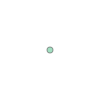

In [255]:
gdf.loc[0, 'geometry']

In [270]:
places_df = pd.concat([places_df.loc[~places_df.url.isin(gdf.url)], gdf], ignore_index=True ).drop_duplicates('url')

## Карта
На месте пустоты - кладбище

In [136]:
places_df['geometry'] = places_df.geometry.astype(str)

C:\Users\yupes\anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [137]:
places_df.geometry = [shapely.wkt.loads(r['geometry']) for i, r in places_df.iterrows()]

<AxesSubplot:>

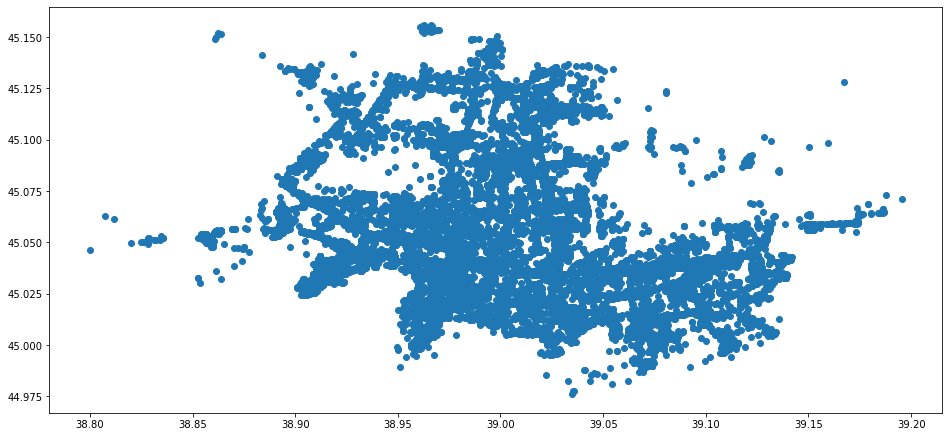

In [294]:
places_df.plot(figsize = (16, 15))

## Статистика

Топ-20 по отзывам

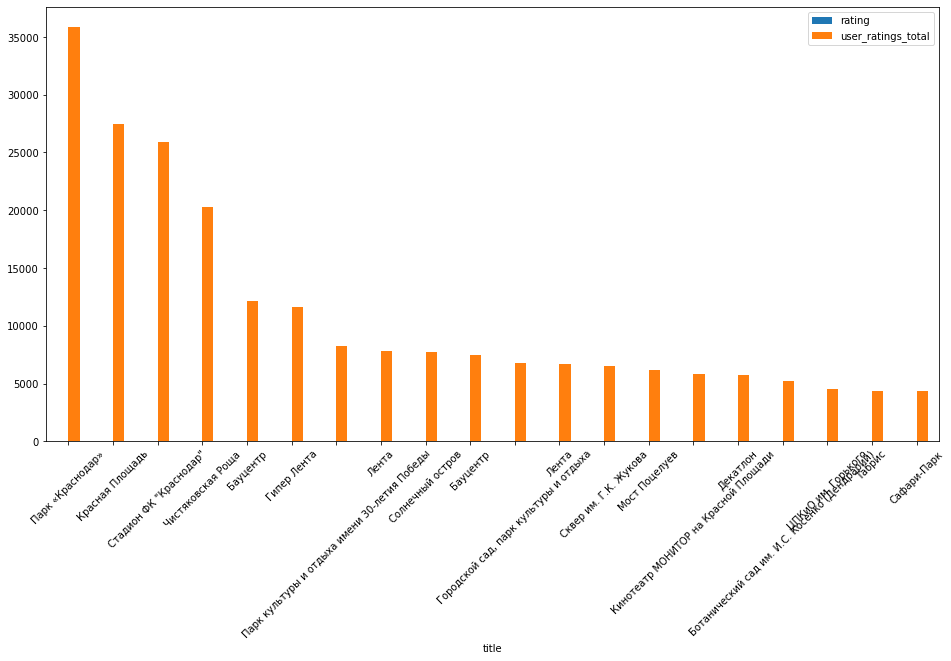

In [4]:
# ax =  places_df.sort_values('user_ratings_total', ascending = False)[:20].plot(kind = 'bar', rot = 45, x = 'title', figsize = (16, 8))


In [5]:
places_df.shape

(15527, 10)

Поиск обязательных аттракторов: 

Присутствуют:
+ Парк Краснодар (Галицкого) 	Близко к району проектирования, современный парк, - нельзя с собаками
+ Парк Солнечный остров	Требует ухода, есть пляж, проблема с вывозом мусора
+ Сафари-парк	Зоопарк на территории с солнечного острова, запущенный
+ Парк 30-летия Победы	Военный музей, набережная реки Кубань
+ Парк Рождественский	Место «пикников», неблагоустроенный 
+ Старая Кубань	Пляж, грязный, грязная река
+ Сквер Дружбы	Ухоженный сквер в центре, многолюдный
+ Ботанический сад им. профессора И. С. Косенко Ухоженный, уютный
+ Чистяковская роща	Много зелени, несколько запущенный 
+ Сквер им. Маршала Г.К. Жукова	Маленький уютный сквер, напротив администрации
- Городской сад	Исторический парк, проблемы с аттракционом
- Городской сад	Парк в начале Красной улицы, нравится горожанам
- Учебный Ботанический Сад	Иногда открыт только для экскурсий (Ботанический сад 1/ КубГУ)

In [22]:
places_df.loc[places_df.title.str.contains('Солнечный')]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total,count_photo
389,https://www.google.com/maps/place/?q=place_id:...,"Совхоз ""Солнечный"" 2-е отделение","Краснодарский край, 350012",Автобусная остановка,NaN,POINT (38.90287000000001 45.088045),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN,NaN
1441,https://www.google.com/maps/place/?q=place_id:...,Солнечный сад,"ул. Новороссийская, 2а, Краснодар, Краснодарск...",Цветочный магазин,NaN,POINT (39.000688 45.022289),"['florist', 'point_of_interest', 'store', 'est...",4.7,7.0,4
2741,https://www.google.com/maps/place/?q=place_id:...,Солнечный остров,"Краснодар, Краснодарский край, 350002",Парк развлечений,"['Загруженность в 04:00: 1%.', 'Загруженность ...",POINT (39.0543808 45.0073079),"['amusement_park', 'tourist_attraction', 'poin...",4.6,7730.0,13271
7246,https://www.google.com/maps/place/?q=place_id:...,ЖК «Солнечный Парк»,"ул. имени Симиренко, 37, Краснодар, Краснодарс...",Офис компании,NaN,POINT (38.9486478 45.07223889999999),"['point_of_interest', 'establishment']",4.1,117.0,140
7872,https://www.google.com/maps/place/?q=place_id:...,Детский сад № 182 Солнечный город,"ул. Жлобы, 143, Краснодар, Краснодарский край,...",Детский сад,NaN,POINT (39.0326589 45.0468647),"['school', 'point_of_interest', 'establishment']",3.6,12.0,15
8383,https://www.google.com/maps/place/?q=place_id:...,"ООО ""Научно-Техническая компания ""Солнечный це...","ул. Атарбекова, 1/1, Краснодар, Краснодарский ...",Производитель,NaN,POINT (38.9422739 45.0602295),"['point_of_interest', 'establishment']",2.9,9.0,36
9041,https://www.google.com/maps/place/?q=place_id:...,"Краснодарский Центр Йоги Айенгара ""Солнечный""","ул. Архитектора Ишунина, д. 8/20, Краснодар, К...",Студия йоги,NaN,POINT (38.9580084 45.0660845),"['gym', 'health', 'point_of_interest', 'establ...",4.8,4.0,4
10167,https://www.google.com/maps/place/?q=place_id:...,Свх Солнечный 2ое. Отд.16,"Краснодар, Краснодарский край, 350053",Пивоварня,NaN,POINT (38.911658 45.08958800000001),"['food', 'point_of_interest', 'establishment']",5.0,1.0,NaN
10208,https://www.google.com/maps/place/?q=place_id:...,"Совхоз ""Солнечный"" 2-е отделение","Краснодар, Краснодарский край, 350012",Автобусная остановка,"['Загруженность в 04:00: 0%.', 'Загруженность ...",POINT (38.904421 45.089211),"['transit_station', 'point_of_interest', 'esta...",5.0,2.0,NaN
10770,https://www.google.com/maps/place/?q=place_id:...,Солнечный,"ул. Атарбекова, 1, Краснодар, Краснодарский кр...",Аптека,NaN,POINT (38.9557398 45.060954),"['pharmacy', 'health', 'point_of_interest', 's...",NaN,NaN,NaN


# Возможные категории

In [214]:
places_df.title.fillna('', inplace = True)

In [215]:
places_df.category.fillna('', inplace = True)

In [216]:
places_df['new_category'] = ''

Можно выделить доп категории: магазин, здоровье, машины, еда, школа, услуги

In [274]:
places_df['types'].apply(lambda s: list(ast.literal_eval(s))).explode().str.split('_').explode().value_counts().reset_index().to_csv('../data/types.csv', index = False)

In [275]:
places_df.loc[places_df.category != '','category'].str.lower().explode().str.split(' ').explode().value_counts().reset_index().to_csv('../data/category.csv', index = False)

In [331]:
places_df['types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts().reset_index().to_csv('../data/types_GP.csv')

In [277]:
places_df.loc[places_df.category != '','category'].str.lower().value_counts().reset_index().to_csv('../data/category_GP.csv', index = False)

Услуга

In [217]:
places_df.loc[(places_df.types.str.contains('car_repair|beauty_salon|hair_care|real_estate_agency|travel_agency|car_dealer|spa|florist|car_rental|car_wash|plumber|electrician|moving_company|laundry|lawyer|funeral_home|post_office|locksmith|painter|insurance_agency|gas_station|bank')), 'new_category'] \
    = "Услуга"

Магазины

In [263]:
places_df.loc[((places_df.title.str.lower().str.contains('магазин'))|\
               (places_df.category.str.lower().str.contains('магазин'))|\
               (places_df.types.str.contains('store|shop')))&\
              ~((places_df.types.str.contains('bakery'))|\
                (places_df.types.str.contains('restaurant'))|\
                (places_df.types.str.contains('cafe'))|\
                (places_df.types.str.contains('bar'))), 'new_category'] = "Магазин"

Образовательные учереждения

In [219]:
places_df.loc[(places_df.types.str.contains('school|university|secondary_school|primary_school'))&\
              (places_df.category !="Магазин фермерских товаров"), 'new_category'] = "Образование"

Здоровье

In [220]:
places_df.loc[places_df.types.str.contains('health'), "new_category"] = "Здоровье"

Спорт

Можем говорить о том, что все спортзалы (gym) относятся к категории здоровья

In [130]:
places_df.loc[places_df.types.str.contains('gym'), 'types'].apply(lambda s: list(ast.literal_eval(s))).explode().str.split('_').explode().value_counts()[:20]

gym              111
point            111
of               111
interest         111
establishment    111
health           111
spa               11
bar                4
night              3
club               3
lodging            3
food               2
salon              2
beauty             2
hospital           2
restaurant         2
store              1
stadium            1
hair               1
care               1
Name: types, dtype: int64

In [285]:
places_df.loc[places_df.types.str.contains('stadium')]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
206,https://www.google.com/maps/place/?q=place_id:...,КСК,"ул. Камвольная, 8, Краснодар, Краснодарский кр...",Стадион,NaN,POINT (39.06804 45.02338),"['stadium', 'point_of_interest', 'establishment']",4.6,445.0
1617,https://www.google.com/maps/place/?q=place_id:...,"Стадион ФК ""Краснодар""","ул. Разведчика Леонова, 1, Краснодар, Краснода...",Стадион,NaN,POINT (39.02919 45.04449),"['stadium', 'gym', 'health', 'point_of_interes...",4.9,25865.0
8120,https://www.google.com/maps/place/?q=place_id:...,Cтадион Академии ФК «Краснодар»,"ул. Жлобы, 114, Краснодар, Краснодарский край,...",Стадион,NaN,POINT (39.03835 45.04954),"['stadium', 'point_of_interest', 'establishment']",NaN,NaN
12928,https://www.google.com/maps/place/?q=place_id:...,стадион КубГАУ,"ул. Калинина, 13, Краснодар, Краснодарский кра...",Стадион,NaN,POINT (38.92303 45.04790),"['stadium', 'point_of_interest', 'establishment']",4.7,58.0
15329,https://www.google.com/maps/place/?q=place_id:...,УСЦ Покровские озера,"Краснодар, Краснодарский край, 350038",Стадион,NaN,POINT (39.00131 45.02933),"['stadium', 'point_of_interest', 'establishment']",4.6,207.0


In [221]:
places_df.loc[(places_df.types.str.contains('gym'))|(places_df.types.str.contains('stadium')), 'new_category'] = "Спорт"

Определение улиц с большим числом категории еда

In [314]:
food_streets = places_df.loc[places_df.types.str.contains('food'), 'address'].str.split(',').explode().str.lower().str.strip().value_counts().reset_index()

In [287]:
food_streets.loc[(~food_streets['index'].str.contains('ул')) & (~food_streets['index'].str.isnumeric())][3:40]

,index,address
45,пр. чекистов,23
82,знаменский,12
83,остановочный комплекс,12
129,"трц ""красная площадь""",7
137,1 этаж,7
139,свх краснодарский 4 отделение,7
142,пр. репина,7
147,79/1,6
161,8 корпус 1,6
165,кружевная,6


In [291]:
food_streets = places_df.loc[places_df.types.str.contains('restaurant'), 'address'].str.split(',').explode().str.lower().str.strip().value_counts().reset_index()
food_streets.loc[(~food_streets['index'].str.contains('ул')) & (~food_streets['index'].str.isnumeric())][3:40]

,index,address
33,пр. чекистов,12
85,79/1,4
88,8 корпус 1,4
119,3 этаж,3
120,"трц ""красная площадь""",3
148,лента,3
149,9/1,3
157,2 этаж,3
184,59/1,2
193,2/2,2


<AxesSubplot:>

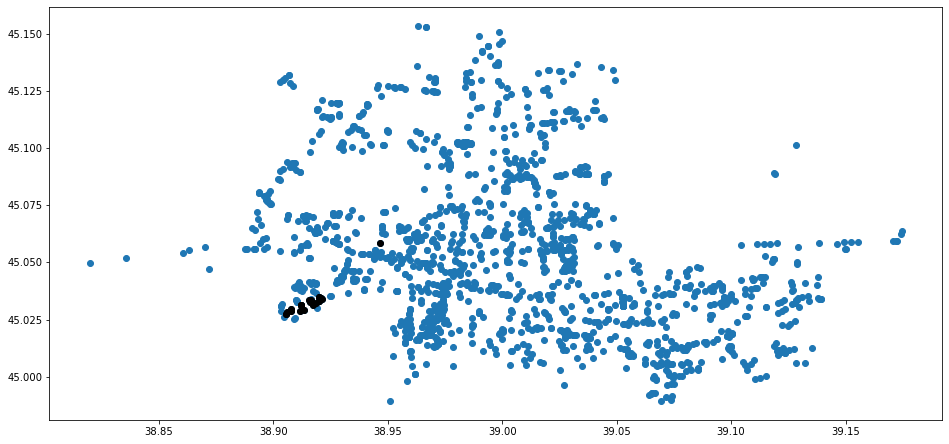

In [296]:
ax = places_df.loc[places_df.types.str.contains('food')].plot(figsize = (16, 15))
places_df.loc[(places_df.types.str.contains('food')) &places_df.address.str.lower().str.contains('чекистов')].plot(ax = ax, color = 'k')

In [49]:
places_df.loc[(places_df.types.str.contains('restaurant'))|(places_df.types.str.contains('cafe'))|(places_df.types.str.contains('bar'))]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total,count_photo,new_category
66,https://www.google.com/maps/place/?q=place_id:...,Шашлычный двор,"ул. Тюляева, 43, Краснодар, Краснодарский край...",Ресторан,NaN,POINT (39.0960469 45.0396082),"['restaurant', 'food', 'point_of_interest', 'e...",4.2,176.0,10,
132,https://www.google.com/maps/place/?q=place_id:...,KFC,"ул. Александра Покрышкина, д. 3, Краснодар, Кр...",Фастфуд,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.9497861 45.1079132),"['restaurant', 'food', 'point_of_interest', 'e...",2.3,27.0,3,
168,https://www.google.com/maps/place/?q=place_id:...,Палитра Суши,"Кружевная, 5, Краснодар, Краснодарский край, 3...",Суши,NaN,POINT (39.06545699999999 44.99295389999999),"['restaurant', 'food', 'point_of_interest', 'e...",NaN,NaN,NaN,
169,https://www.google.com/maps/place/?q=place_id:...,Flat White Flat,"Конгрессная, 23, Краснодар, Краснодарский край...",Кофейня,NaN,POINT (38.9624194 45.1072286),"['cafe', 'food', 'point_of_interest', 'store',...",4.5,2.0,NaN,
199,https://www.google.com/maps/place/?q=place_id:...,RAI-SPA,NaN,,"['Загруженность в 04:00: 87%.', 'Загруженность...",POINT (39.01081070000001 45.0110473),"['night_club', 'spa', 'lodging', 'bar', 'healt...",4.8,283.0,298,Здоровье
...,...,...,...,...,...,...,...,...,...,...,...
15482,https://www.google.com/maps/place/?q=place_id:...,Pallermo,"Рождественская наб., 4, Краснодар, Краснодарск...",Ресторан,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.9089698 45.025444),"['restaurant', 'meal_delivery', 'food', 'point...",4.6,45.0,68,
15489,https://www.google.com/maps/place/?q=place_id:...,Тихий берег,"ул. Калинина, 1/16, Краснодар, Краснодарский к...",Кафе,NaN,POINT (38.8971557 45.0565597),"['cafe', 'food', 'point_of_interest', 'establi...",3.0,2.0,NaN,
15495,https://www.google.com/maps/place/?q=place_id:...,Сказка,"ул. Кубанская набережная, 52/3, Краснодар, Кра...",Кафе,"['Загруженность в 04:00: 45%.', 'Загруженность...",POINT (38.9600799 45.0192345),"['cafe', 'meal_takeaway', 'restaurant', 'food'...",4.4,176.0,21,
15522,https://www.google.com/maps/place/?q=place_id:...,Мадьяр-Гриль,"ул. Дзержинского, 100, Краснодар, Краснодарски...",Ресторан,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.9831636 45.1007007),"['restaurant', 'bar', 'food', 'point_of_intere...",4.6,170.0,32,


Общепит

In [264]:
places_df.loc[((places_df.types.str.contains('bakery'))|\
               (places_df.types.str.contains('restaurant'))|\
               (places_df.types.str.contains('cafe'))|\
               (places_df.types.str.contains('bar'))), 'new_category'] = "Общепит"

Остановка

In [133]:
places_df.loc[places_df.category.str.lower().str.contains('остановка'), 'category'].value_counts()

Автобусная остановка                  206
Остановка                              13
Остановка общественного транспорта      4
Трамвайная остановка                    4
Остановка трамвая                       1
Name: category, dtype: int64

In [223]:
places_df.loc[places_df.category.str.lower().str.contains('остановка'), 'new_category'] = "Остановка ОТ"

ЖК

In [341]:
places_df.loc[places_df.title.str.lower().str.contains('жк ')].types.apply(lambda s: list(ast.literal_eval(s))).explode().value_counts()

point_of_interest          160
establishment              160
transit_station             27
general_contractor          18
real_estate_agency           5
finance                      3
lodging                      2
store                        1
local_government_office      1
bus_station                  1
hair_care                    1
Name: types, dtype: int64

In [44]:
places_df.loc[(places_df.title.str.lower().str.contains('жк '))&\
              ~(places_df.category.str.lower().str.contains('автобусная остановка')) |\
             (places_df.category.str.lower().str.contains('жилой комплекс')), 'category'].value_counts()

Жилой комплекс                   127
Офис компании                     10
Строительная компания              9
Многоквартирный дом                7
Жилое здание                       6
Агентство недвижимости             3
Скейт-парк                         2
Генеральный подрядчик              2
Компания-застройщик                2
Компания ЖКХ                       2
Жилищное управление                1
Ночлег                             1
Жилищно-строительная компания      1
Магазин                            1
Танцевальный зал                   1
Апартаменты для отдыха             1
Автостанция                        1
                                   1
Ликвидатор имущества               1
Почтовая служба                    1
Школа парикмахеров                 1
Студенческий жилой комплекс        1
Name: category, dtype: int64

In [224]:
places_df.loc[(places_df.title.str.lower().str.contains('жк '))|\
             (places_df.category.str.lower().str.contains('жилой комплекс')), 'new_category'] = "Жилой комплекс"

Соотношение русский и англ категорий

In [357]:
gt = pd.read_csv('../data/groups_types.csv')
types = pd.read_csv('../data/types_GP.csv')

In [410]:
gt[84:]

,идентификатор,индекс,типы
84,35,Бухгалтерский учет,82.0
85,41,хранение,66.0
86,46,local_government_office,58.0
87,9,финансы,558.0
88,10,жилье,448.0
89,5,генеральный подрядчик,849.0
90,19,транзитная станция,235.0
91,20,банкомат,209.0
92,57,night_club,38.0
93,74,парковка,12.0


In [411]:
', '.join(types.loc[gt[84:]['идентификатор'], 'index'].to_list())

'accounting, storage, local_government_office, finance, lodging, general_contractor, transit_station, atm, night_club, parking, courthouse, premise, fire_station, police, political, roofing_contractor, embassy'

In [409]:
places_df.loc[(~places_df.types.str.contains('car'))&\
              (places_df.types.str.contains('bus_station|light_rail_station|transit_station'))]
#               (places_df.types.str.contains('|'.join(types.loc[gt[82:84]['идентификатор'], 'index'].to_list())))]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
93,https://www.google.com/maps/place/?q=place_id:...,ул. Булгакова,"Краснодар, Краснодарский край, 350005",Автобусная остановка,NaN,POINT (38.96062 45.10694),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
139,https://www.google.com/maps/place/?q=place_id:...,ул. Булгакова,"Краснодар, Краснодарский край, 350005",Автобусная остановка,NaN,POINT (38.96164 45.10690),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
251,https://www.google.com/maps/place/?q=place_id:...,"ЖК ""Матрёшки""","Краснодарский край, 350073",Автобусная остановка,NaN,POINT (39.02663 45.09525),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
256,https://www.google.com/maps/place/?q=place_id:...,"ЖК ""Матрёшки""","Краснодарский край, 350073",Автобусная остановка,NaN,POINT (39.02664 45.09515),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
263,https://www.google.com/maps/place/?q=place_id:...,ул. Базарная,"Краснодар, Краснодарский край, 350088",Автобусная остановка,NaN,POINT (39.11068 45.05292),"['transit_station', 'point_of_interest', 'esta...",5.0,1.0
...,...,...,...,...,...,...,...,...,...
15407,https://www.google.com/maps/place/?q=place_id:...,"ТРК ""Красная Площадь""","Краснодар, Краснодарский край, 350005",Остановка,NaN,POINT (38.98164 45.10116),"['transit_station', 'point_of_interest', 'esta...",4.9,14.0
15409,https://www.google.com/maps/place/?q=place_id:...,Тургеневский мост,"Краснодар, Краснодарский край, 350004",Остановка,NaN,POINT (38.95167 45.03719),"['transit_station', 'point_of_interest', 'esta...",5.0,1.0
15410,https://www.google.com/maps/place/?q=place_id:...,Площадь,"Краснодар, Краснодарский край, 350910",Трамвайная остановка,NaN,POINT (39.09468 45.02319),"['transit_station', 'point_of_interest', 'esta...",2.0,1.0
15451,https://www.google.com/maps/place/?q=place_id:...,ул. Кубано-Набережная,"Краснодар, Краснодарский край, 350000",Остановка,NaN,POINT (38.95959 45.02944),"['transit_station', 'point_of_interest', 'esta...",4.7,6.0


Локальности

In [225]:
places_df.loc[(places_df.types.str.contains('locality|political|neighborhood|sublocality|sublocality_level_2|sublocality_level_1|airport|cemetery')), 'new_category'] \
    = "Локальность" 

открытые общественные пространства = 
Парк+Сквер+Бульвар(40), Сад (6)
площадь(10)
набережная (1)
Озеро (32)
пляж (4):
'tourist_attraction, park, natural_feature, town_square, amusement_park, zoo'

Помещения культурные(47)
театр+музей+галерея+церковь, собор+библиотека:

развлекательные
кинотеатр + боулинг
парк развлечений, 
зоопарк,

'bowling_alley, art_gallery, movie_theater, place_of_worship, library'

Зеленые зоны:

парк, сад, ботанический сад, экологический парк, сквер, бульвар

In [92]:
places_df.loc[(places_df.types.str.contains("'park'")) & ~(places_df.types.str.contains('car'))].category.value_counts()

Парк                                                39
Сад                                                  4
Мемориальный парк                                    2
Магазин строительных товаров                         2
Ботанический сад                                     2
Магазин кровельных материалов                        1
                                                     1
Услуги обрезки и удаления деревьев и кустарников     1
Экологический парк                                   1
Name: category, dtype: int64

In [157]:
places_df.loc[((places_df.category.str.contains('Парк|Сад|Ботанический сад|Экологический парк'))&\
             ~(places_df.category.str.contains('аттракционов|развлечений')) | \
              (places_df.title.str.lower().str.contains('сквер'))) & (places_df.new_category=='')]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total,count_photo,new_category
2764,https://www.google.com/maps/place/?q=place_id:...,"Старая Кубань, городской пляж","ул. Парусная, 4, Краснодар, Краснодарский край...",Парк,"['Загруженность в 04:00: 1%.', 'Загруженность ...",POINT (39.06201069999999 45.00649079999999),"['park', 'point_of_interest', 'establishment']",4.5,776.0,1299,
2866,https://www.google.com/maps/place/?q=place_id:...,TreeTopPark,"с, ул. Трамвайная, 2 строение 8, Краснодар, Кр...",Парк,NaN,POINT (39.0561363 45.007544),"['park', 'point_of_interest', 'establishment']",2.7,3.0,26,
10304,https://www.google.com/maps/place/?q=place_id:...,Все для сада,"ул. Российская, 127/2, Краснодар, Краснодарски...",Сад,NaN,POINT (39.0183358 45.0463114),"['park', 'point_of_interest', 'establishment']",4.5,35.0,6,
10610,https://www.google.com/maps/place/?q=place_id:...,Тополинный Дом,"ул. Московская, 111/1, Краснодар, Краснодарски...",Парк,NaN,POINT (39.00004560000001 45.0887941),"['park', 'point_of_interest', 'establishment']",4.2,25.0,3,
15293,https://www.google.com/maps/place/?q=place_id:...,Сквер Памяти,"ул. Российская, 259, Краснодар, Краснодарский ...",Исторический памятник,NaN,POINT (39.0138127 45.0894762),"['point_of_interest', 'establishment']",4.6,30.0,34,
15306,https://www.google.com/maps/place/?q=place_id:...,Городской Сад. Аттракционы,"ул. Постовая, 34, Краснодар, Краснодарский кра...",Парк,NaN,POINT (38.9711173 45.0133366),"['park', 'point_of_interest', 'establishment']",0.0,0.0,NaN,
15350,https://www.google.com/maps/place/?q=place_id:...,Покровское Озеро,"ул. Карасуно - наб., 83, Краснодар, Краснодарс...",Парк,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.9953075 45.0267367),"['park', 'point_of_interest', 'establishment']",4.4,503.0,744,


In [226]:
places_df.loc[[253, 15198, 15283, 15291, 15311], 'new_category'] = "Сад"
places_df.loc[[15307,15305,10855,15250, 15304,15237,15209,15248,15303, 15302, 15301,15298,15297, 15296,15295,15294, 15290,15289,15287], 'new_category'] = "Сквер"
places_df.loc[[15300, 15308,15285], 'new_category'] = "Бульвар"
places_df.loc[[15309, 15299, 15281,15269,15203,15200,14197,6359,4419,3031,2905,1791,1610], 'new_category'] = "Парк"

In [227]:
places_df.loc[7765, 'new_category'] = "Образование"

In [228]:
places_df.loc[[2866,634, 645], 'new_category'] = "Зоопарк"

In [278]:
places_df.loc[(places_df.types.str.lower().str.contains('bowling_alley')), 'new_category'] = 'Боулинг'

In [230]:
places_df.loc[[687, 15462], 'new_category'] = "Кинотеатр"

In [231]:
places_df.loc[(places_df.types.str.lower().str.contains('art_gallery')), 'new_category'] = "Галерея"

In [232]:
places_df.loc[(places_df.category.str.lower().str.contains('музей'))|\
             (places_df.types.str.lower().str.contains('museum'))|\
             (places_df.title.str.lower().str.contains('музей')), 'new_category'] = "Музей"

In [233]:
places_df.loc[(places_df.category.str.lower() == 'театр'), 'new_category'] = "Театр"

In [234]:
places_df.loc[(places_df.types.str.lower().str.contains('library')), 'new_category'] = "Библиотека"

In [237]:
places_df.loc[(places_df.types.str.lower().str.contains('natural')), 'new_category'] = "Озеро"
places_df.loc[[15350,15273], 'new_category'] = "Озеро"

In [238]:
places_df.loc[[15368, 15340, 15333, 2934, 2764],'new_category'] = "Пляж"

In [239]:
places_df.loc[(places_df.types.str.lower().str.contains('place_of_worship|chur')), 'new_category'] = 'Религия'

In [240]:
places_df.loc[((places_df.category.str.lower().str.contains('церковь|храм|собор|религ'))|\
              (places_df.title.str.lower().str.contains('церковь|храм|собор|религ')))&
             (places_df.new_category==''), "new_category"] = "Религия"

In [241]:
places_df.loc[(places_df.category.str.lower().str.contains('аттрак'))|
             (places_df.category.str.lower().str.contains('развле'))|
             (places_df.title.str.lower().str.contains('аттрак')), 'new_category'] = 'Развлечение'
places_df.loc[9004, 'new_category'] = 'Развлечение'

In [242]:
places_df.loc[[674,2741, 3039, 14834,15306, 15310], 'new_category'] = "Аттракционы"

In [122]:
print(places_df.loc[15300, 'url'])

https://www.google.com/maps/place/?q=place_id:ChIJLWcJG45F8EAROh7ZotqOsGA


Достопримечательность=

памятник, достопримечательность, культурный объект, дома, фонтаны, деревья

In [253]:
places_df.loc[((places_df.category.str.lower().str.contains('памятник|мемори'))) & \
              ~(places_df.category.str.lower().str.contains('изготовитель')), 'new_category'] = "Памятник"

In [254]:
places_df.loc[(places_df.title.str.lower().str.contains('достопримечательность'))|\
              (places_df.category.str.lower().str.contains('достопримечательность')), 'new_category'] = 'Достопримечательность'

Набережная

In [111]:
places_df.loc[(places_df.title.str.lower().str.contains('набережная'))]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total,count_photo,new_category
15225,https://www.google.com/maps/place/?q=place_id:...,Кубанская набережная,"Западный, Краснодар, Краснодарский край, 350000",Смотровая площадка,NaN,POINT (38.9579842 45.0331629),"['tourist_attraction', 'point_of_interest', 'e...",4.5,2084.0,1182,
15345,https://www.google.com/maps/place/?q=place_id:...,Кубанонабережная Мост Поцелуев,"ул. Береговая, 146/1, Краснодар, Краснодарский...",Мост,NaN,POINT (38.95464200000001 45.018457),"['point_of_interest', 'establishment']",3.7,3.0,3,
15382,https://www.google.com/maps/place/?q=place_id:...,Кубанская набережная 24,"ул. Кубанская набережная, 122, Краснодар, Крас...",Компьютерный клуб,NaN,POINT (38.9603402 45.0214147),"['point_of_interest', 'establishment']",0.0,0.0,2,
15394,https://www.google.com/maps/place/?q=place_id:...,101 квест Кубанская набережная 31/1 - квесты д...,"ул. Кубанская набережная, 31/1, Краснодар, Кра...",Детский развлекательный центр,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.958027 45.02193700000001),"['point_of_interest', 'establishment']",5.0,8.0,11,
15412,https://www.google.com/maps/place/?q=place_id:...,101 квест Кубанская Набережная 64 - квесты для...,"ул. Кубанская набережная, д. 64, Краснодар, Кр...",Квест-комнаты,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.9603157 45.0219726),"['point_of_interest', 'establishment']",4.7,55.0,16,
15445,https://www.google.com/maps/place/?q=place_id:...,Набережная,"ул. Кубанская набережная, Краснодар, Краснодар...",Ночной клуб,"['Загруженность в 04:00: 11%.', 'Загруженность...",POINT (38.9586625 45.0318895),"['night_club', 'point_of_interest', 'establish...",4.6,20.0,43,
15451,https://www.google.com/maps/place/?q=place_id:...,ул. Кубано-Набережная,"Краснодар, Краснодарский край, 350000",Остановка,NaN,POINT (38.959594 45.029441),"['transit_station', 'point_of_interest', 'esta...",4.7,6.0,43,Остановка ОТ
15465,https://www.google.com/maps/place/?q=place_id:...,Морковь Набережная | Фрукты•Овощи•Орехи,"ул. Кубанская набережная, 33, Краснодар, Красн...",Продажа фруктов и овощей,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.95949520000001 45.0232675),"['grocery_or_supermarket', 'food', 'point_of_i...",4.7,86.0,21,Магазин


In [255]:
places_df.loc[[15382, 15225, 15445, 15451], 'new_category'] = "Набережная"

Площадь

In [256]:
places_df.loc[(places_df.category.str.lower().str.contains('площадь')), 'new_category'] = "Площадь" 

Мост

In [141]:
places_df.loc[(places_df.title.str.lower().str.contains("^мост|мост | мост"))|(places_df.category.str.lower() == "мост")]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total,count_photo,new_category
1699,https://www.google.com/maps/place/?q=place_id:...,Мост Жумаринг Альпинизм Прыжки с веревкой,"2к1, ул. Заводская, 2 корпус 1, Краснодар, Кра...",Школа,NaN,POINT (39.1096524 44.9969877),"['school', 'point_of_interest', 'establishment']",NaN,NaN,NaN,Образование
2814,https://www.google.com/maps/place/?q=place_id:...,Навесной мост,"Краснодар, Краснодарский край, 350058",Мост,"['Загруженность в 04:00: 4%.', 'Загруженность ...",POINT (39.0540962 45.0036163),"['point_of_interest', 'establishment']",4.4,29.0,33,
6864,https://www.google.com/maps/place/?q=place_id:...,Мост-Техника,"ул. Лизы Чайкиной, 1, Краснодар, Краснодарский...",Автотранспорт,NaN,POINT (39.0560762 45.030368),"['point_of_interest', 'establishment']",NaN,NaN,NaN,
7557,https://www.google.com/maps/place/?q=place_id:...,Железный мост,"оз. Старая, Кубань, Краснодарский край, 350011",Мост,"['Загруженность в 04:00: 23%.', 'Загруженность...",POINT (39.04094389999999 44.98793729999999),"['point_of_interest', 'establishment']",4.6,57.0,47,
7563,https://www.google.com/maps/place/?q=place_id:...,Пантонный мост,"оз. Старая Кубань, Краснодар, Краснодарский край",Достопримечательность,NaN,POINT (39.04074850000001 44.98788400000001),"['tourist_attraction', 'point_of_interest', 'e...",NaN,NaN,NaN,
8608,https://www.google.com/maps/place/?q=place_id:...,"МОСТ2000, агентство недвижимости","ул. А.М. Новицкого, 2/5, цокольный этаж, Красн...",Агентство недвижимости,NaN,POINT (38.9434328 45.0607743),"['real_estate_agency', 'point_of_interest', 'e...",NaN,NaN,NaN,Услуга
10480,https://www.google.com/maps/place/?q=place_id:...,Северные мосты,"ул. Северная, Краснодар, Краснодарский край, 3...",Мост,"['Загруженность в 04:00: 1%.', 'Загруженность ...",POINT (39.0097118 45.0348773),"['point_of_interest', 'establishment']",3.7,376.0,28,
12361,https://www.google.com/maps/place/?q=place_id:...,Южный Мост Тур,"ул. Садовая, 105, Краснодар, Краснодарский кра...",Турагентство,NaN,POINT (38.99337540000001 45.0370462),"['travel_agency', 'point_of_interest', 'establ...",4.0,1.0,NaN,Услуга
15219,https://www.google.com/maps/place/?q=place_id:...,Тургеневский мост,"Тургеневское ш., Краснодар, Краснодарский край...",Мост,"['Загруженность в 04:00: 1%.', 'Загруженность ...",POINT (38.95330000000001 45.03550000000001),"['tourist_attraction', 'point_of_interest', 'e...",3.9,1130.0,405,
15235,https://www.google.com/maps/place/?q=place_id:...,Мост Поцелуев,"ул. Кубанонабережная, Краснодар, Краснодарский...",Мост,"['Загруженность в 04:00: 1%.', 'Загруженность ...",POINT (38.9577894 45.0253057),"['tourist_attraction', 'point_of_interest', 'e...",4.4,6223.0,4233,


In [257]:
places_df.loc[[15474, 15450, 15417,15398, 15373,  15345, 15338, 15335,15235,15219,10480,7563,7557,2814],'new_category'] = "Мост"

In [273]:
places_df.loc[places_df.new_category=='', 'types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts()

establishment              7387
point_of_interest          7387
general_contractor          705
lodging                     393
finance                     357
atm                         167
food                        146
accounting                   73
local_government_office      48
storage                      41
veterinary_care              36
police                       21
roofing_contractor           13
courthouse                   10
parking                       9
fire_station                  4
park                          3
premise                       2
night_club                    1
embassy                       1
tourist_attraction            1
Name: types, dtype: int64

In [287]:
places_df.loc[(places_df.new_category=='')& (places_df.types.str.contains('finance'))].category.value_counts()

Банкомат                                            162
Бухгалтер                                            23
Нотариус                                             22
Бухгалтерские услуги                                 18
Сертифицированный общественный аудитор               11
Оценщик                                              11
Лизинг                                               10
Инвестиционная компания                              10
Услуги безналичных денежных переводов                 8
Юридические услуги                                    7
Ликвидатор имущества                                  6
Налоговая инспекция                                   5
Кредитный союз                                        5
Бухгалтерская фирма                                   4
Оценка недвижимости                                   4
Закрыто навсегда                                      3
Оценщик недвижимости                                  3
Финансовый консультант                          

In [286]:
places_df.loc[(places_df.new_category=='')& (places_df.types.str.contains('lodging')), 'new_category'] = 'Жилье'

In [285]:
places_df.loc[(places_df.types.str.contains('cloth')), 'new_category'] = 'Магазин одежды'

In [276]:
places_df.loc[(places_df.new_category=='')& (places_df.types.str.contains('tourist_attraction')), 'new_category'] =  'Культура'

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total,count_photo,new_category
15195,https://www.google.com/maps/place/?q=place_id:...,Планетарий,"Парк ""Солнечный остров"", Парк ""Солнечный остро...",Планетарий,"['Загруженность в : %.', 'Загруженность в : %....",POINT (39.0578453 45.0131593),"['tourist_attraction', 'point_of_interest', 'e...",4.1,14.0,13,


In [272]:
places_df.loc[(places_df.new_category=='')& (places_df.types.str.contains('bus_station')), 'new_category'] = "Остановка ОТ"

In [316]:
places_df.loc[places_df.category.str.contains('Доставка готовой еды|Фреш-бар|Доставка пиццы|Ресторан или кафе|Кейтеринг|Пивоварня|Винодельня|Кафе-кондитерская'), 'new_category'] = 'Общепит'

In [309]:
places_df.new_category.drop_duplicates()

0                       Услуга
1                             
2                      Магазин
7                        Жилье
13                 Локальность
15              Жилой комплекс
17              Магазин одежды
25                    Здоровье
45                 Образование
66                     Общепит
93                Остановка ОТ
204                    Религия
206                      Спорт
253                        Сад
325                      Музей
634                    Зоопарк
674                Аттракционы
687                  Кинотеатр
697                   Памятник
1454                   Боулинг
1610                      Парк
1655                       Еда
2626                Библиотека
2666               Развлечение
2764                      Пляж
2814                      Мост
6088                   Площадь
7536                     Театр
7928     Достопримечательность
10760                  Галерея
10855                    Сквер
15225               Набережная
15285   

In [325]:
places_df.loc[10610, 'new_category'] = "Магазин"

In [326]:
places_df['new_category_2'] = places_df.new_category

In [327]:
places_df.loc[places_df.new_category.isin(['Магазин', 'Магазин одежды']),'new_category_2'] = "Магазин"
places_df.loc[places_df.new_category.isin(['Жилье', 'Услуга']),'new_category_2'] = "Услуга"
places_df.loc[places_df.new_category.isin(['Религия', 'Музей', "Библиотека", "Театр", "Галерея"]),'new_category_2'] = "Культура"
places_df.loc[places_df.new_category.isin(['Жилье', 'Услуга']),'new_category_2'] = "Услуга"
places_df.loc[places_df.new_category.isin(['Сад', 'Парк', "Бульвар", "Сквер"]),'new_category_2'] = "Зеленые зоны"
places_df.loc[places_df.new_category.isin(['Достопримечательность',"Памятник"]),'new_category_2'] = "Достопримечательность"
places_df.loc[places_df.new_category.isin(['Кинотеатр', 'Развлечение', "Аттракционы", "Зоопарк", "Боулинг"]),'new_category_2'] = "Развлечения"

In [328]:
places_df.new_category_2.value_counts()

                         6993
Магазин                  4279
Услуга                   1968
Здоровье                  600
Общепит                   466
Образование               379
Жилой комплекс            206
Остановка ОТ              205
Спорт                     108
Достопримечательность      93
Культура                   64
Зеленые зоны               40
Развлечения                33
Озеро                      32
Локальность                31
Мост                       14
Площадь                     9
Набережная                  4
Пляж                        3
Name: new_category_2, dtype: int64

In [329]:
places_df.drop([0, 13819],inplace = True)

In [339]:
places_df = pd.read_csv('../data/places_GP.csv')

In [349]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
places_df['normalized_rating'] = scaler.fit_transform(places_df[['user_ratings_total', 'rating', 'count_photo']].fillna(0)).sum(axis = 1)

In [398]:
places_df.to_csv('../data/places_GP.csv', index = False)